

# BERT ESG Classifier
Multilabel, usando `content`


**Pruebas:** Bajar num epochs a 25 y si eso seguir en bloques de 25
*   Probar con class weights
*   Probar Early Stopping
*   Probar a quitar capas Densas
*   Probar version de 1024
*   Probar lo de la metrica custom del loss para multilabel
*   Probar learning rate scheduler como callback basado en el ejemplo de clase de NER (optimizador triangular)


Esta es la variante multilabel

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q tensorflow-text
!pip install -q tf-models-official
!pip install -q -U keras-tuner

     |████████████████████████████████| 4.6 MB 3.0 MB/s 
     |████████████████████████████████| 511.7 MB 5.3 kB/s 
     |████████████████████████████████| 438 kB 77.0 MB/s 
     |████████████████████████████████| 1.6 MB 70.8 MB/s 
     |████████████████████████████████| 5.8 MB 82.6 MB/s 
     |████████████████████████████████| 2.1 MB 4.2 MB/s 
     |████████████████████████████████| 636 kB 61.2 MB/s 
     |████████████████████████████████| 352 kB 62.9 MB/s 
     |████████████████████████████████| 99 kB 10.2 MB/s 
     |████████████████████████████████| 92 kB 11.6 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 237 kB 55.8 MB/s 
     |████████████████████████████████| 1.2 MB 58.5 MB/s 
     |████████████████████████████████| 1.1 MB 58.8 MB/s 
     |████████████████████████████████| 48.3 MB 105.2 MB/s 
     |████████████████████████████████| 133 kB 4.2 MB/s 


In [3]:
import os
import shutil
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.utils import shuffle, class_weight
from sklearn.metrics import multilabel_confusion_matrix, classification_report

import altair as alt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

In [4]:
# Leer CSVS
path_train = "/content/drive/Shareddrives/UCM SHARED/TFM_ESG/HTML Extracts/html_extract_10pc_data_train.csv"
path_test = "/content/drive/Shareddrives/UCM SHARED/TFM_ESG/HTML Extracts/html_extract_10pc_data_test.csv"

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

Análisis distribución etiquetas

In [5]:
df_labels = df_train[['E', 'S', 'G']].astype(bool)
df_counts = df_labels.apply(pd.value_counts)
print(df_counts)

           E     S     G
False  11430  4388  9186
True     533  7575  2777


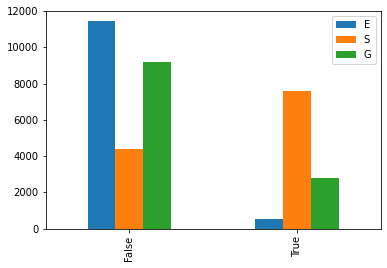

In [6]:
df_counts.plot.bar()

In [7]:
df_rates = df_labels.value_counts(normalize=True).mul(100)
df_rates

E      S      G    
False  True   False    43.885313
       False  False    31.321575
       True   True     15.556299
       False  True      4.781409
True   True   True      2.557887
              False     1.320739
       False  True      0.317646
              False     0.259132
dtype: float64

In [8]:
X_train = df_train['content']
y_train = df_train[['E', 'S', 'G']]

X_test = df_test['content']
y_test = df_test[['E', 'S', 'G']]

Para fine-tuning, se utilizará la matriz pooled_output.

# Define el modelo

In [9]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/2',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/2',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/2',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/2',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/2',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/2',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/2',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/2',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/2',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/2',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/2',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/2',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/2',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/2',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/2',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/2',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/2',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/2',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/3',
    'electra_small':
        'https://tfhub.dev/google/electra_small/3',
    'electra_base':
        'https://tfhub.dev/google/electra_base/3',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/3',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/3',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

In [10]:

def build_classifier_model(encoder, processer, epochs_set, initial_learning_rate):
    # Definición de la entrada del modelo
    text_input = tf.keras.layers.Input(
        shape=(),
        dtype=tf.string,
        name='text'
    )
    # Definición del preprocesador para bert
    preprocessing_layer = hub.KerasLayer(
        processer,
        name='preprocessing'
    )
    encoder_inputs = preprocessing_layer(text_input)

    # Definición del Modelo Bert para codificar la información.
    encoder = hub.KerasLayer(
        encoder,
        trainable=True,
        name='BERT_encoder'
    )
    outputs = encoder(encoder_inputs)
   
    # Seleccionamos la representación del documento entero.
    net = outputs['pooled_output']
   
    # Definimos la arquitectura del modelo de salida ajustada a la tarea
    net = tf.keras.layers.Dropout(0.5)(net)
    net = tf.keras.layers.Dense(units = 384, activation='relu')(net)
    net = tf.keras.layers.Dense(units = 192, activation='relu')(net)
    net = tf.keras.layers.Dense(units = 96, activation='relu')(net)
    net = tf.keras.layers.Dense(units = 48, activation='relu')(net)
    net = tf.keras.layers.Dense(units = 24, activation='relu')(net)
    net = tf.keras.layers.Dense(units = 12, activation='relu')(net)
    net = tf.keras.layers.Dense(units = 6, activation='relu')(net)  
    net = tf.keras.layers.Dense(units = 3, activation='sigmoid', name='classifier')(net)
    
    classifier_model = tf.keras.Model(text_input, net)
    
    # Definición del optimizador para el problema
    epochs = epochs_set
    steps_per_epoch = df_train.shape[0]
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
   
    optimizer = optimization.create_optimizer(
        init_lr=initial_learning_rate,
        num_train_steps=num_train_steps,
        num_warmup_steps=num_warmup_steps,
        optimizer_type='adamw'
      )
    # Compilación del modelo
    classifier_model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
      )

    return classifier_model 

Una vez definido el modelo vamos a contruirlo realizando la llamada a la función anterior.

In [11]:
num_epochs = 50

# Modelo para Environment
model = build_classifier_model(
    tfhub_handle_encoder,
    tfhub_handle_preprocess,
    num_epochs,
    5e-5
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
# Entrenamiento Fine Tuning
checkpoint_filepath = '/content/drive/MyDrive/ESG_BERT_Train/ESG_Multilabel_Train/RAW_Content/check'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(x=X_train,
                    y=y_train,
                    validation_split=0.1,
                    batch_size=32,
                    epochs=num_epochs, 
                    callbacks=[model_checkpoint_callback]
                    )

Epoch 1/50
337/337 [==============================] - 219s 599ms/step - loss: 0.7381 - accuracy: 0.3427 - val_loss: 0.7106 - val_accuracy: 0.3409
Epoch 2/50
337/337 [==============================] - 194s 576ms/step - loss: 0.7134 - accuracy: 0.3491 - val_loss: 0.6987 - val_accuracy: 0.3350
Epoch 3/50
337/337 [==============================] - 193s 573ms/step - loss: 0.7051 - accuracy: 0.3478 - val_loss: 0.6951 - val_accuracy: 0.3166
Epoch 4/50
337/337 [==============================] - 193s 573ms/step - loss: 0.6984 - accuracy: 0.3401 - val_loss: 0.6940 - val_accuracy: 0.3208
Epoch 5/50
337/337 [==============================] - 193s 574ms/step - loss: 0.6964 - accuracy: 0.3425 - val_loss: 0.6929 - val_accuracy: 0.3141
Epoch 6/50
337/337 [==============================] - 194s 574ms/step - loss: 0.6932 - accuracy: 0.3392 - val_loss: 0.6900 - val_accuracy: 0.3158
Epoch 7/50
337/337 [==============================] - 193s 574ms/step - loss: 0.6878 - accuracy: 0.3328 - val_loss: 0.6847 -

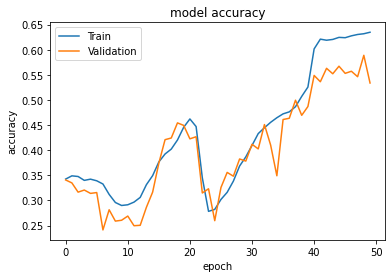

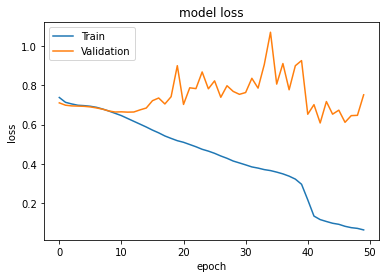

In [ ]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

In [27]:
preds_proba = model.predict(X_test)
preds = preds_proba.round().astype(int).tolist()
#preds = [np.argmax(i) for i in preds]

42/42 [==============================] - 9s 225ms/step


In [29]:
preds_str = [str(i) for i in preds]
y_test_str = [str(i) for i in y_test.values.tolist()]

In [30]:
data_tuples = list(zip(preds_str , y_test_str))
dataset_test = pd.DataFrame(data_tuples,columns=["pred","real"])

In [31]:
# Configure common options
base = alt.Chart(dataset_test).transform_aggregate(
    count='count()',
    groupby=['pred', 'real']
).encode(
    alt.X('pred:O', scale=alt.Scale(paddingInner=0)),
    alt.Y('real:O', scale=alt.Scale(paddingInner=0)),
).properties(
    width=500,
    height=500
)

# Configure heatmap
heatmap = base.mark_rect().encode(
    color=alt.Color('count:Q',
        scale=alt.Scale(scheme='viridis'),
        legend=alt.Legend(direction='vertical')
    )
)

# Configure text
text = base.mark_text(baseline='middle').encode(
    text='count:Q',
    color=alt.condition(
        alt.datum.count > 100,
        alt.value('black'),
        alt.value('white')
    )
)

# Draw the chart
heatmap + text

alt.LayerChart(...)

In [32]:
matrix = multilabel_confusion_matrix(y_test.values.tolist(), preds)
matrix 

array([[[1235,   37],
        [  26,   32]],

       [[ 369,  119],
        [ 146,  696]],

       [[ 943,   78],
        [ 164,  145]]])

In [33]:
print(classification_report(y_test.values.tolist(), preds, output_dict=False, target_names=['E', 'S', 'G']))

              precision    recall  f1-score   support

           E       0.46      0.55      0.50        58
           S       0.85      0.83      0.84       842
           G       0.65      0.47      0.55       309

   micro avg       0.79      0.72      0.75      1209
   macro avg       0.66      0.62      0.63      1209
weighted avg       0.78      0.72      0.75      1209
 samples avg       0.54      0.51      0.51      1209



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
!pip install mlcm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
from mlcm import mlcm


conf_mat, normal_conf_mat = mlcm.cm(y_test.values.tolist(), preds)
print('\nRaw confusion Matrix:')
print(conf_mat)
print('\nNormalized confusion Matrix (%):')
print(normal_conf_mat)

one_vs_rest = mlcm.stats(conf_mat)

MLCM has one extra row (NTL) and one extra column (NPL).        
Please read the following paper for more information:
        Heydarian et al., MLCM: Multi-Label Confusion Matrix, IEEE Access,2022        
To skip this message, please add parameter "print_note=False"
        e.g., conf_mat,normal_conf_mat = mlcm.cm(label_true,label_pred,False)

Raw confusion Matrix:
[[ 32   2   5  24]
 [ 17 696  50 138]
 [ 16  17 145 150]
 [  9 101  28 296]]

Normalized confusion Matrix (%):
[[51.  3.  8. 38.]
 [ 2. 77.  6. 15.]
 [ 5.  5. 44. 46.]
 [ 2. 23.  6. 68.]]
[[[1137   42]
  [  31   32]]

 [[ 473  120]
  [ 205  696]]

 [[1024   83]
  [ 183  145]]

 [[ 873  312]
  [ 138  296]]]

       class#     precision        recall      f1-score        weight

            0          0.43          0.51          0.47          63
            1          0.85          0.77          0.81          901
            2          0.64          0.44          0.52          328
          NTL          0.49          0.68    

https://stackoverflow.com/questions/48254832/keras-class-weight-in-multi-label-binary-classification

https://stackoverflow.com/questions/48485870/multi-label-classification-with-class-weights-in-keras

https://stackoverflow.com/questions/68374999/is-this-the-correct-use-of-sklearn-classification-report-for-multi-label-classif

https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea


# Referencias



1.   Multi-Label Classification with Deep Learning - *Jason Brownlee on August 31, 2020* - https://machinelearningmastery.com/multi-label-classification-with-deep-learning/
2.   Deep Learning for Multi-label Classification - *Jesse Read, Fernando Perez-Cruz* - https://arxiv.org/pdf/1502.05988.pdf




